In [1]:
%load_ext autoreload

In [3]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from data_utils import get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks

plt.style.use('/om2/user/eisenaj/code/UniversalUnconsciousness/sci_style.mplstyle')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [144]:
with initialize(version_base="1.3", config_path="../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [145]:
# data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class)) if f.endswith('.mat')]
session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]

# session_list = [session_list[1]]
# session_list = [session_list[2]]
# session_list = ['SPOCK_Ketamine_20210712', 'PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220203']
# session_list = ['PEDRI_Ketamine_20220113']

In [146]:
# session = [session for session in session_list if 'Dex' in session][0]

In [234]:
# session = 'Mary-Anesthesia-20160809-01'
# session = "PEDRI_Ketamine_20220222"
session = "SPOCK_Ketamine_20210715"

In [235]:
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, ['sessionInfo', 'electrodeInfo', 'lfp'], data_class=cfg.params.data_class)
session_info, electrode_info, lfp = session_vars['sessionInfo'], session_vars['electrodeInfo'], session_vars['lfp']

Loading data: ['sessionInfo', 'electrodeInfo', 'lfp', 'lfpSchema']...
sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

electrodeInfo : dict with keys[Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

lfp : numpy.array(21141618,128,) of type float64

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

Data loaded (took 108.38 seconds)


In [236]:
# avg_std_dev = lfp.std(axis=0).mean()
# std_dev_mult = 8
# bad_electrodes = []
# worst_electrode_example = []
# window = 15
# window_starts = np.arange(0, T*dt - window, window)
# for window_start in tqdm(window_starts):
#     window_end = window_start + window
#     lfp_vals = lfp[int(window_start/dt):int(window_end/dt)]
#     bad_electrodes.append(np.sum(np.abs(lfp_vals).max(axis=0) > avg_std_dev*std_dev_mult))
#     worst_electrode_example.append(lfp_vals[:, np.argmax(lfp_vals.max(axis=0))])

# plt.figure(figsize=(2, 1))
# plt.hist(bad_electrodes, bins=30)
# plt.xlabel('Number of Bad Electrodes')
# plt.ylabel('Number of Windows')
# plt.title(f"{session}\nelectrodes with max greater than {std_dev_mult}" + r"$\sigma_{avg}$")
# plt.show()

# bad_electrode_indices = [i for i, num_bad in enumerate(bad_electrodes) if num_bad > 0 ]

# # bad_elec_ind = 0
# # window_ind = bad_electrode_indices[bad_elec_ind]

# window_ind = int(np.argmax(np.array(bad_electrodes) > 2))
# # window_ind = -9


# lfp_vals = lfp[int(window_starts[window_ind]/dt):int((window_starts[window_ind] + window)/dt)]
# max_vals = np.abs(lfp_vals).max(axis=0)
# sorted_inds = np.argsort(max_vals)
# bad_boolean = max_vals > std_dev_mult*avg_std_dev
# plt.figure(figsize=(3, 1.5))
# plt.subplot(1, 2, 1)
# offset = 0
# for i in np.where(bad_boolean)[0][:10]:
#     plt.plot(lfp_vals[:, i] + offset)
#     offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
# plt.title('Bad Electrodes')
# plt.xlabel('Time (ms)')
# plt.subplot(1, 2, 2)
# offset = 0
# for i in sorted_inds[:-np.max([np.sum(bad_boolean), 1])][::-1][:10]:
#     plt.plot(lfp_vals[:, i] + offset)
#     offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
# plt.title('Good Electrodes')
# plt.xlabel('Time (ms)')
# plt.show()

In [237]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

In [238]:
section_info

[('awake lever1', [-36.08934555555556, np.float64(-26.03372388888889)]),
 ('awake oddball',
  [np.float64(-26.03372388888889), np.float64(-10.018529444444445)]),
 ('awake lever2', [np.float64(-10.018529444444445), 0]),
 ('induction', [0, np.float64(9.992232777777781)]),
 ('unconscious oddball',
  [np.float64(9.992232777777781), np.float64(26.00725333333333)]),
 ('early unconscious',
  [np.float64(26.00725333333333), np.float64(137.11107361111112)]),
 ('late unconscious',
  [np.float64(137.11107361111112), np.float64(316.2107433333333)]),
 ('recovery oddball',
  [np.float64(300.22940055555557), np.float64(316.2107433333333)])]

In [153]:
drug_start = session_info['drugStart'][0] if 'propofol' in cfg.params.data_class else session_info['infusionStart']
section_std_devs = {}
for section, section_times in tqdm(section_info):
    section_start, section_end = int((section_times[0]*60 + drug_start)/dt), int((section_times[1]*60 + drug_start)/dt)
    section_std_devs[section] = lfp[section_start:section_end].std()
    # lfp[int((section_times[0]*60 + drug_start)/dt)

  0%|          | 0/8 [00:00<?, ?it/s]

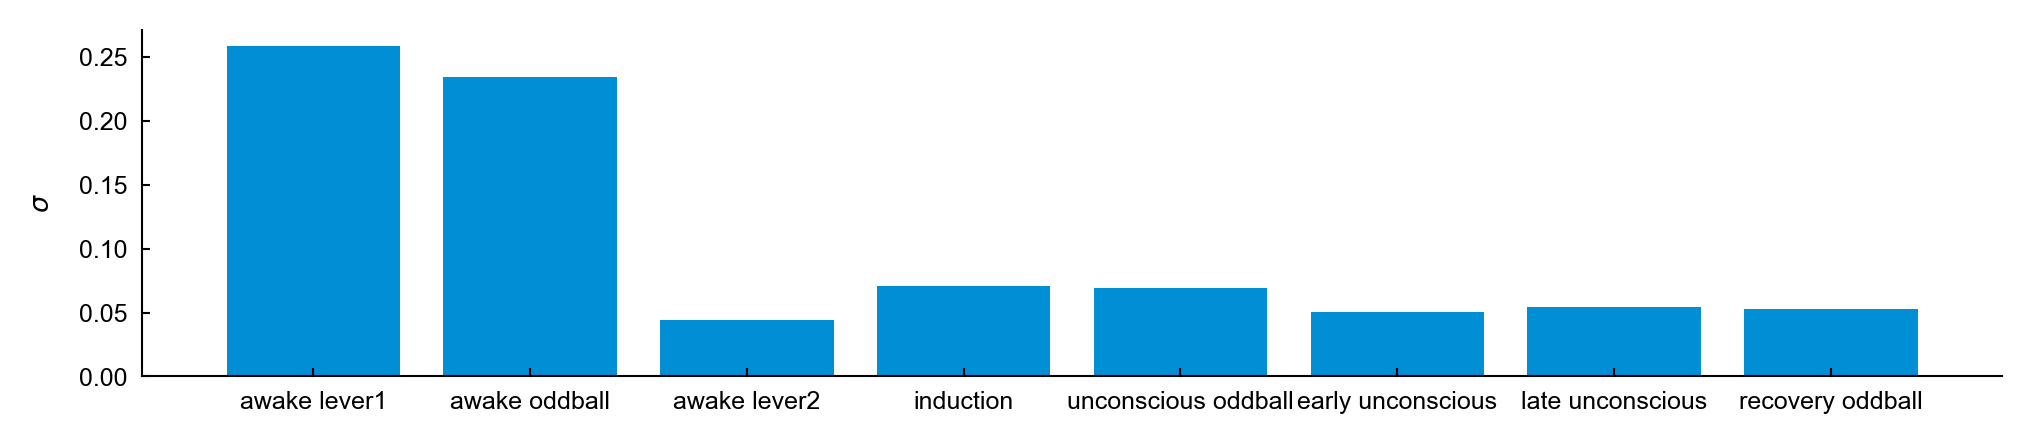

In [156]:
plt.figure(figsize=(8, 1.5))
plt.bar(section_std_devs.keys(), section_std_devs.values())
plt.ylabel(r'$\sigma$')
plt.show()

In [196]:
sigma_mult = 15
window_starts = np.arange(0, T*dt - window, window)
bad_electrode_df = []
window_starts = np.arange(0, T*dt - window, window)
for window_start in tqdm(window_starts):
    window_end = window_start + window
    if (window_start - drug_start)/60 >= section_info[0][1][0] and (window_end - drug_start)/60 <= section_info[-1][1][1]:
        window_section = [section for section, section_times in section_info if (window_end - drug_start)/60 <= section_times[1]][0]
        std_dev_section = section_std_devs[window_section]
        lfp_window = lfp[int(window_start/dt):int(window_end/dt)]
        lfp_max = lfp_window.max(axis=0)
        bad_electrode_inds = np.where(np.abs(lfp_max) >= sigma_mult*std_dev_section)[0]
        num_bad_electrodes = len(bad_electrode_inds)

        bad_electrode_df.append(dict(
            window_start=window_start,
            window_end=window_end,
            lfp_max=lfp_max,
            bad_electrode_inds=bad_electrode_inds,
            section=window_section,
            num_bad_electrodes=num_bad_electrodes
        ))
bad_electrode_df = pd.DataFrame(bad_electrode_df)

  0%|          | 0/913 [00:00<?, ?it/s]

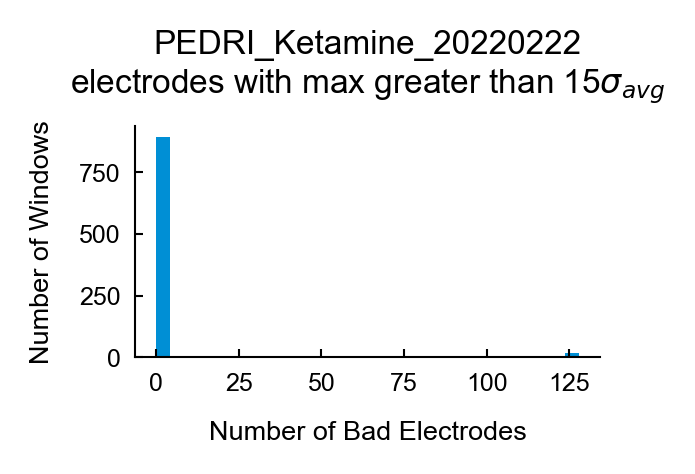

In [197]:
plt.figure(figsize=(2, 1))
plt.hist(bad_electrode_df.num_bad_electrodes, bins=30)
plt.xlabel('Number of Bad Electrodes')
plt.ylabel('Number of Windows')
plt.title(f"{session}\nelectrodes with max greater than {sigma_mult}" + r"$\sigma_{avg}$")
plt.show()

In [198]:
bad_electrode_df[bad_electrode_df.num_bad_electrodes > 0].index.to_numpy()

array([ 12,  16,  28,  45,  46,  50,  58,  83,  91, 112, 116, 119, 122,
       123, 135, 136, 142, 143, 144, 148, 150, 152, 154, 155, 156, 162,
       181, 201, 219, 221, 227, 228, 238, 257, 260, 261, 264, 272, 286,
       288, 303, 322, 348, 349, 350, 351, 353, 356, 358, 359, 361, 362,
       363, 364, 365, 375, 380, 384, 385, 412, 415, 420, 421, 444, 463,
       464, 468, 469, 478, 490, 493, 497, 498, 501, 507, 517, 533, 534,
       538, 539, 540, 541, 542, 543, 544, 546, 548, 549, 553, 554, 555,
       557, 562, 571, 575, 581, 588, 599, 602, 615, 620, 621, 622, 632,
       635, 637, 640, 641, 642, 643, 644, 651, 654, 655, 656, 657, 658,
       659, 660, 663, 665, 668, 690, 695, 696, 697, 705, 709, 710, 711,
       714, 716, 727, 729, 732, 733, 734, 736, 739, 740, 743, 744, 749,
       753, 755, 758, 760, 761, 762, 763, 772, 773, 774, 775, 776, 777,
       778, 784, 785, 786, 787, 788, 790, 797, 799, 800, 802, 803, 806,
       807, 812, 822, 823, 825, 826, 836, 842, 843, 850, 851, 85

In [217]:
bad_idx = 48

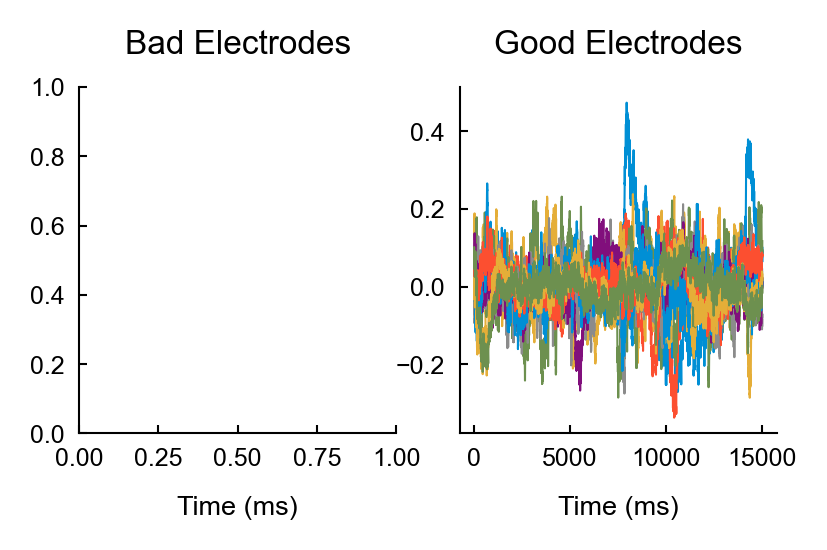

In [218]:
row = bad_electrode_df.loc[bad_idx]

lfp_vals = lfp[int(row.window_start/dt):int((row.window_end)/dt)]
max_vals = np.abs(lfp_vals).max(axis=0)
sorted_inds = np.argsort(max_vals)
bad_boolean = max_vals >= sigma_mult*section_std_devs[row.section]
plt.figure(figsize=(3, 1.5))
plt.subplot(1, 2, 1)
offset = 0
for i in np.where(bad_boolean)[0][:10]:
    plt.plot(lfp_vals[:, i] + offset)
    # offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Bad Electrodes')
plt.xlabel('Time (ms)')
plt.subplot(1, 2, 2)
offset = 0
for i in sorted_inds[:-np.max([np.sum(bad_boolean), 1])][::-1][:np.min([np.sum(bad_boolean), 10]) if np.sum(bad_boolean) > 0 else 10]:
    plt.plot(lfp_vals[:, i] + offset)
    # offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Good Electrodes')
plt.xlabel('Time (ms)')
plt.show()

In [239]:
bad_electrode_df = []
window_starts = np.arange(0, T*dt - window, window)
for window_start in tqdm(window_starts):
    window_end = window_start + window
    lfp_window = lfp[int(window_start/dt):int(window_end/dt)]
    lfp_max = lfp_window.max(axis=0)
    bad_electrode_inds = np.where(np.abs(lfp_max) >= 1)[0]
    num_bad_electrodes = len(bad_electrode_inds)
   
    bad_electrode_df.append(dict(
        window_start=window_start,
        window_end=window_end,
        lfp_max=lfp_max,
        bad_electrode_inds=bad_electrode_inds,
        section=window_section,
        num_bad_electrodes=num_bad_electrodes
    ))
bad_electrode_df = pd.DataFrame(bad_electrode_df)

  0%|          | 0/1409 [00:00<?, ?it/s]

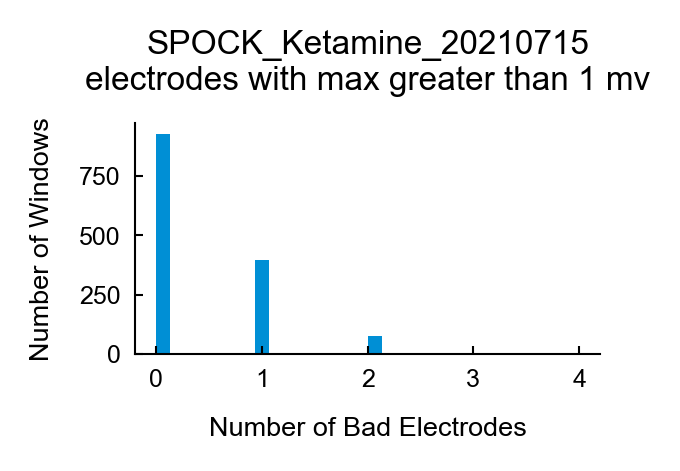

In [250]:
plt.figure(figsize=(2, 1))
plt.hist(bad_electrode_df.num_bad_electrodes, bins=30)
plt.xlabel('Number of Bad Electrodes')
plt.ylabel('Number of Windows')
plt.title(f"{session}\nelectrodes with max greater than 1 mv")
plt.show()

In [241]:
bad_electrode_df[bad_electrode_df.num_bad_electrodes > 0].index.to_numpy()

array([   3,    4,    5,    7,   12,   15,   18,   20,   26,   27,   29,
         30,   31,   34,   38,   41,   47,   49,   52,   54,   58,   59,
         60,   61,   64,   66,   74,   82,   87,   92,   93,   95,   96,
        105,  107,  108,  110,  111,  115,  119,  120,  122,  128,  130,
        131,  133,  136,  145,  147,  148,  157,  159,  164,  171,  174,
        177,  178,  180,  187,  188,  189,  192,  193,  194,  196,  197,
        199,  202,  209,  213,  214,  216,  220,  221,  223,  224,  225,
        228,  231,  233,  234,  235,  240,  244,  252,  255,  259,  262,
        265,  267,  270,  272,  277,  278,  279,  282,  284,  285,  291,
        292,  295,  297,  298,  299,  308,  310,  311,  316,  319,  320,
        321,  323,  326,  327,  328,  331,  334,  335,  339,  340,  343,
        344,  346,  349,  350,  353,  354,  355,  357,  358,  368,  372,
        373,  374,  375,  376,  380,  385,  386,  387,  388,  390,  391,
        392,  393,  394,  395,  397,  398,  399,  4

In [242]:
np.sum(bad_electrode_df.num_bad_electrodes > 0)/len(bad_electrode_df)

np.float64(0.3435060326472676)

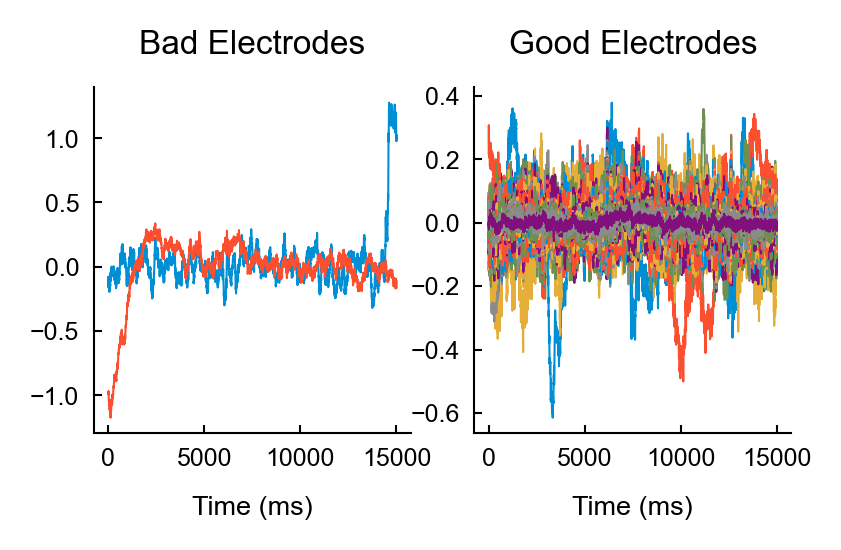

In [281]:
bad_idx = 4

row = bad_electrode_df.loc[bad_idx]

lfp_vals = lfp[int(row.window_start/dt):int((row.window_end)/dt)]
max_vals = np.abs(lfp_vals).max(axis=0)
sorted_inds = np.argsort(max_vals)
bad_boolean = max_vals >= sigma_mult*section_std_devs[row.section]
plt.figure(figsize=(3, 1.5))
plt.subplot(1, 2, 1)
offset = 0
for i in np.where(bad_boolean)[0][:10]:
    plt.plot(lfp_vals[:, i] + offset)
    # offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Bad Electrodes')
plt.xlabel('Time (ms)')
plt.subplot(1, 2, 2)
offset = 0
# for i in sorted_inds[:-np.max([np.sum(bad_boolean), 1])][::-1][:np.min([np.sum(bad_boolean), 10]) if np.sum(bad_boolean) > 0 else 10]:
for i in sorted_inds[:-np.max([np.sum(bad_boolean), 1])][::-1]:
    plt.plot(lfp_vals[:, i] + offset)
    # offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Good Electrodes')
plt.xlabel('Time (ms)')
plt.show()

In [277]:
len(np.where(bad_electrode_df.bad_electrode_inds.apply(lambda x: 18 in x))[0])/len(bad_electrode_df)

0.10290986515259049

In [265]:
bad_electrode_df

,window_start,window_end,lfp_max,bad_electrode_inds,section,num_bad_electrodes
0,0.0,15.0,"[0.2146317236059525, 0.18297847627767888, 0.18...",[],late unconscious,0
1,15.0,30.0,"[0.1808010790353983, 0.18006587345768904, 0.18...",[],late unconscious,0
2,30.0,45.0,"[0.16081513866049058, 0.14777528160113482, 0.1...",[],late unconscious,0
3,45.0,60.0,"[0.2418488960441283, 0.20085363640090823, 0.23...",[91],late unconscious,1
4,60.0,75.0,"[0.19707256323799308, 0.22368873110265164, 0.1...",[69],late unconscious,1
...,...,...,...,...,...,...
1404,21060.0,21075.0,"[0.1468946089231612, 0.14161212411150215, 0.13...",[],late unconscious,0
1405,21075.0,21090.0,"[0.1660908651048847, 0.1440119544218626, 0.139...",[18],late unconscious,1
1406,21090.0,21105.0,"[0.16118331715833317, 0.13036443303142273, 0.1...",[18],late unconscious,1
1407,21105.0,21120.0,"[0.15553359809711997, 0.12564172733093906, 0.1...",[],late unconscious,0


In [258]:
bad_channels = set()
for idx, row in bad_electrode_df.iterrows():
    bad_channels.add(tuple(row.bad_electrode_inds))

In [259]:
bad_channels

{(),
 (np.int64(12),),
 (np.int64(14),),
 (np.int64(14), np.int64(18)),
 (np.int64(14), np.int64(18), np.int64(118)),
 (np.int64(14), np.int64(20)),
 (np.int64(14), np.int64(50)),
 (np.int64(14), np.int64(64)),
 (np.int64(14), np.int64(75)),
 (np.int64(14), np.int64(86)),
 (np.int64(14), np.int64(91)),
 (np.int64(14), np.int64(98)),
 (np.int64(14), np.int64(118)),
 (np.int64(18),),
 (np.int64(18), np.int64(20), np.int64(50)),
 (np.int64(18), np.int64(50)),
 (np.int64(18), np.int64(50), np.int64(91), np.int64(112)),
 (np.int64(18), np.int64(51), np.int64(74)),
 (np.int64(18), np.int64(54)),
 (np.int64(18), np.int64(64)),
 (np.int64(18), np.int64(74)),
 (np.int64(18), np.int64(75)),
 (np.int64(18), np.int64(79)),
 (np.int64(18), np.int64(86)),
 (np.int64(18), np.int64(91)),
 (np.int64(18), np.int64(98)),
 (np.int64(18), np.int64(110)),
 (np.int64(18), np.int64(112), np.int64(125)),
 (np.int64(18), np.int64(118)),
 (np.int64(18), np.int64(124)),
 (np.int64(20),),
 (np.int64(20), np.int64(